# Project 5B: Training Your Own Diffusion Model!

## Setup environment

In [1]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, transforms

import torch.optim as optim
from tqdm import tqdm

/data/anaconda3/envs/gj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part 1: Training a Single-step Denoising UNet


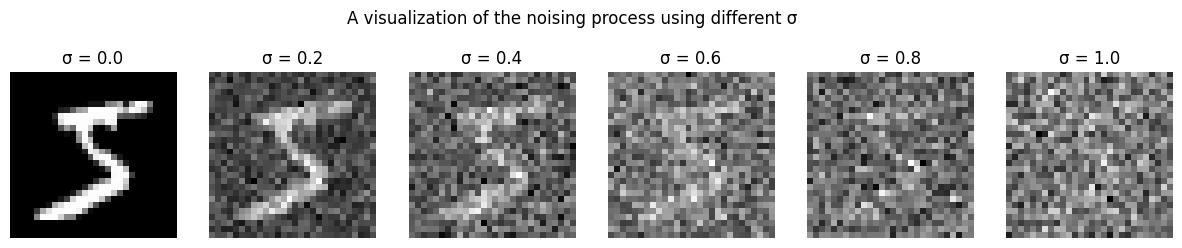

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 

])

train_dataset = MNIST(
    root='./data',
    train=True, 
    transform=transform, 
    download=True 
)

test_dataset = MNIST(
    root='./data',
    train=False, 
    transform=transform
)


image, label = train_dataset[0] 



def add_noise(img, sigma):
    noise = torch.randn_like(img) * sigma
    noisy_img = img + noise
    return noisy_img

sigmas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

def normalize(img):
    img = (img - img.min()) / (img.max() - img.min())
    return img


fig, axes = plt.subplots(1, len(sigmas), figsize=(15, 3))
fig.suptitle('A visualization of the noising process using different σ')


for i, sigma in enumerate(sigmas):
    noisy_image = add_noise(image, sigma)
    axes[i].imshow(normalize(noisy_image).permute(1,2,0), cmap='gray')
    axes[i].set_title(f'σ = {sigma}')
    axes[i].axis('off')

plt.show()

## Implementing Simple and Composed Ops

In [3]:
def forward(x_0, t, alphas_cumprod):
    sqrt_alpha_bar_t = torch.sqrt(alphas_cumprod[t])
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alphas_cumprod[t])
    epsilon = torch.randn(*x_0.shape)
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * epsilon
    print(1,sqrt_one_minus_alpha_bar_t)
    return torch.clamp(x_t, min=-1.0, max=1.0)

In [4]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.layer = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1), 
          nn.BatchNorm2d(out_channels),            
          nn.GELU()          
)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer(x)


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),           
            nn.GELU()
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.down(x)


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),    
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.up(x)


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=7)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.avg_pool(x)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.unflatten = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0),
            nn.BatchNorm2d(in_channels),     
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.unflatten(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block = nn.Sequential(
            Conv(in_channels, out_channels),
            Conv(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block = nn.Sequential(
            DownConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block = nn.Sequential(
            UpConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)

## Implementing Unconditional UNet

In [5]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.enc1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        self.up2 = UpBlock(num_hiddens * 4, num_hiddens * 1)
        self.up1 = UpBlock(num_hiddens * 2, num_hiddens)

        self.dec1 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.final = nn.Conv2d(num_hiddens, in_channels, kernel_size=1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        enc1 = self.enc1(x)
        enc2 = self.down1(enc1)
        enc3 = self.down2(enc2)

        bottleneck = self.flatten(enc3)
        bottleneck = self.unflatten(bottleneck)

        dec2 = self.up2(torch.cat([bottleneck, enc3], dim=1))
        dec1 = self.up1(torch.cat([dec2, enc2], dim=1))
        out = self.dec1(torch.cat([dec1, enc1], dim=1))
        return self.final(out)


In [6]:
def draw_losses_plot(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Batch Loss")
    plt.xlabel("Batch Number")
    plt.ylabel("Loss")
    plt.title("Training Loss Per Batch")
    plt.legend()
    plt.grid()
    plt.show()

100%|██████████| 235/235 [00:29<00:00,  7.87it/s]


Epoch [1/5], Loss: 0.0283


100%|██████████| 235/235 [00:29<00:00,  8.00it/s]


Epoch [2/5], Loss: 0.0113


100%|██████████| 235/235 [00:29<00:00,  8.05it/s]


Epoch [3/5], Loss: 0.0099


100%|██████████| 235/235 [00:29<00:00,  7.98it/s]


Epoch [4/5], Loss: 0.0090


100%|██████████| 235/235 [00:29<00:00,  8.02it/s]


Epoch [5/5], Loss: 0.0085


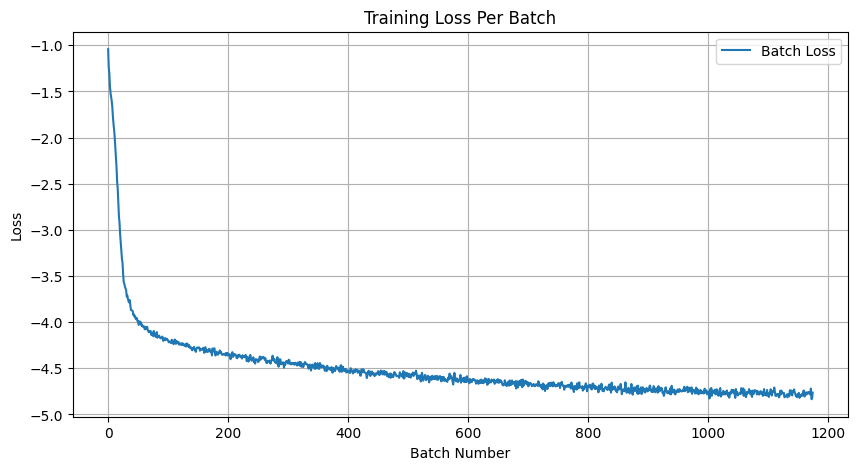

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
model = UnconditionalUNet(in_channels=1, num_hiddens=128)
model = model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5
# num_epochs = 1 # set to 1 to test model performance at 1 epoch

losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for clean_images, _ in tqdm(train_loader):
        clean_images = clean_images.to(device)
        noisy_images = add_noise(clean_images, sigma = 0.5)
        outputs = model(noisy_images)
        loss = criterion(outputs, clean_images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(torch.log(loss).item())
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

draw_losses_plot(losses)

  0%|          | 0/157 [00:00<?, ?it/s]

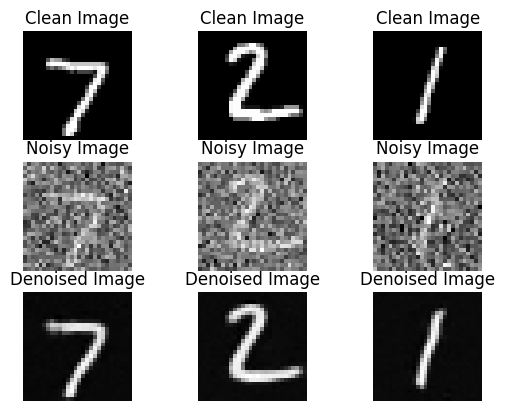

  0%|          | 0/157 [00:00<?, ?it/s]


In [8]:
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


model.eval()
with torch.no_grad():
    for clean_images, _ in tqdm(test_loader):
        clean_images = clean_images.to(device)
        noisy_images = add_noise(clean_images, sigma = 0.5)
        denoised_images = model(noisy_images)
        noisy_images = noisy_images.cpu().numpy()
        denoised_images = denoised_images.cpu().numpy()
        clean_images = clean_images.cpu().numpy()
        for i in range(3):
            plt.subplot(3, 3, i + 1)
            plt.imshow(clean_images[i][0], cmap='gray')
            plt.title("Clean Image")
            plt.axis('off')

            plt.subplot(3, 3, i + 4)
            plt.imshow(noisy_images[i][0], cmap='gray')
            plt.title("Noisy Image")
            plt.axis('off')

            plt.subplot(3, 3, i + 7)
            plt.imshow(denoised_images[i][0], cmap='gray')
            plt.title("Denoised Image")
            plt.axis('off')

        plt.show()
        break

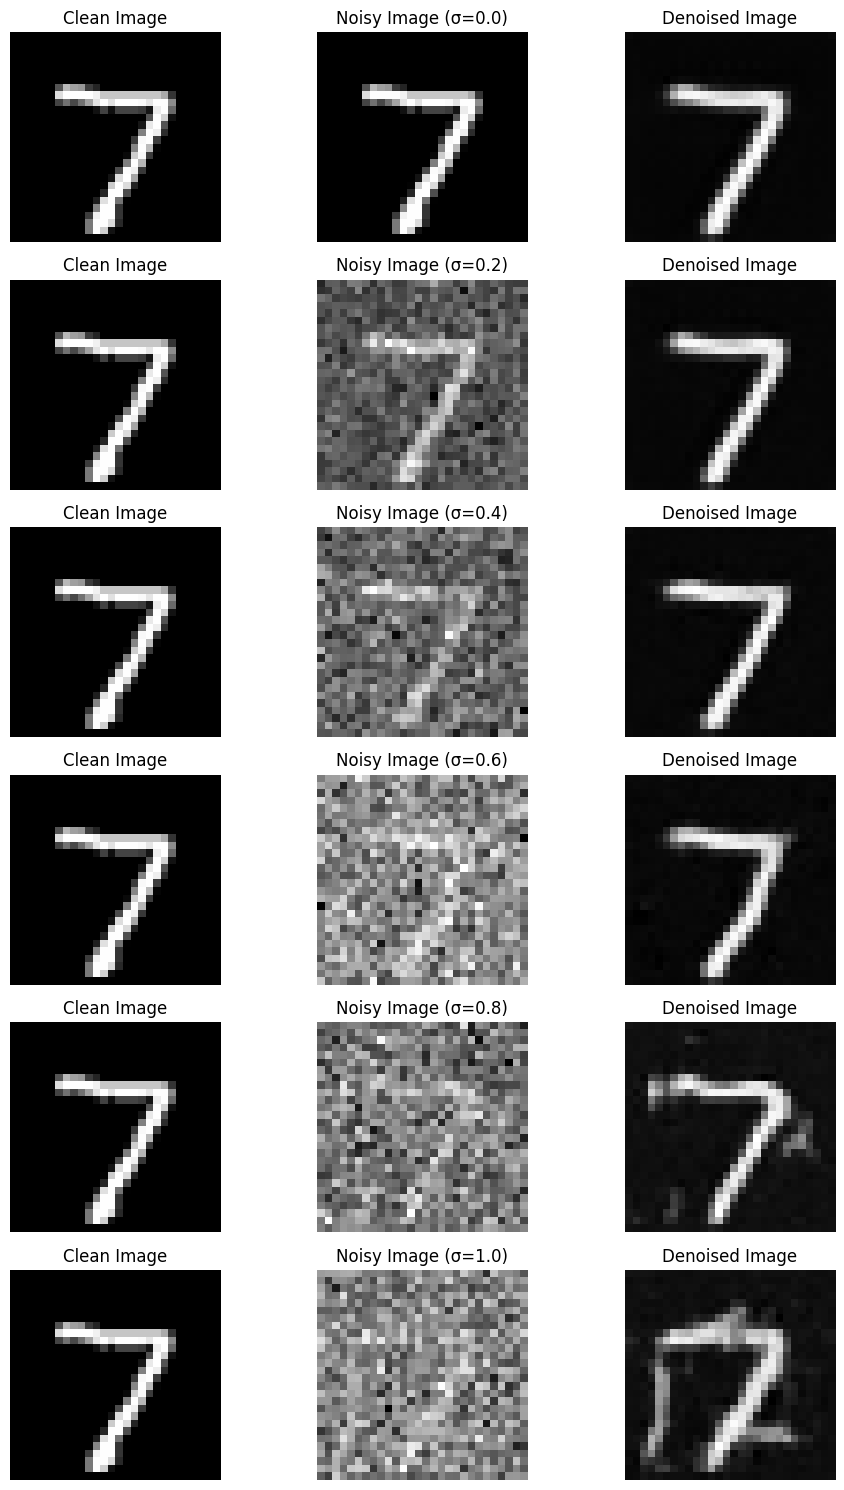

In [9]:
model.eval()

test_images, _ = next(iter(test_loader)) 
test_image = test_images[0:1].to(device)


results = []

for sigma in sigmas:
    noisy_image = add_noise(test_image, sigma=sigma)
    denoised_image = model(noisy_image) 

    results.append({
        "sigma": sigma,
        "noisy_image": noisy_image.detach().cpu(),
        "denoised_image": denoised_image.detach().cpu(),
        "clean_image": test_image.detach().cpu()
    })

import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(sigmas), 3, figsize=(10, 15))
for i, result in enumerate(results):
    axes[i, 0].imshow(result["clean_image"].squeeze(), cmap="gray")
    axes[i, 0].set_title("Clean Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(result["noisy_image"].squeeze(), cmap="gray")
    axes[i, 1].set_title(f"Noisy Image (σ={result['sigma']})")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(result["denoised_image"].squeeze(), cmap="gray")
    axes[i, 2].set_title("Denoised Image")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [11]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=in_channels, out_features=out_channels),
            nn.GELU(), 
            nn.Linear(in_features=out_channels, out_features=out_channels)
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc(x)


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.enc1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        self.up2 = UpBlock(num_hiddens * 4, num_hiddens * 1)
        self.up1 = UpBlock(num_hiddens * 2, num_hiddens)

        self.dec1 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.final = nn.Conv2d(num_hiddens, in_channels, kernel_size=1)

        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)


    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        t = t.unsqueeze(1) / self.num_classes
        t1 = self.fc1_t(t).unsqueeze(2).unsqueeze(3)
        t2 = self.fc2_t(t).unsqueeze(2).unsqueeze(3)

        enc1 = self.enc1(x)
        enc2 = self.down1(enc1)
        enc3 = self.down2(enc2)

        bottleneck = self.flatten(enc3)
        bottleneck = self.unflatten(bottleneck) + t1

        dec2 = self.up2(torch.cat([bottleneck, enc3], dim=1)) + t2
        dec1 = self.up1(torch.cat([dec2, enc2], dim=1))
        out = self.dec1(torch.cat([dec1, enc1], dim=1))
        return self.final(out)

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [12]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    betas = torch.linspace(beta1, beta2, num_ts)
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    return {
        'betas': betas,
        'alphas': alphas,
        'alpha_bars': alpha_bars,
    }

In [13]:
def add_noise(x0, t, ddpm_schedule, noise):
    """
    Args:
        x0: (N, C, H, W) clean images
        t: (N,) time step tensor
        noise: (N, C, H, W) random noise

    Returns:
        xt: Noisy images at time t
    """
    # betas = ddpm_schedule['betas']
    # alphas = ddpm_schedule['alphas']
    alpha_bars = ddpm_schedule['alpha_bars'].to(x0.device)
    sqrt_alpha_t_bar = torch.sqrt(alpha_bars)
    sqrt_1_minus_alpha_t_bar = torch.sqrt(1.0 - alpha_bars)
    # noise = torch.randn_like(x0).to(device)
    batch_size = x0.size(0)
    # print(sqrt_alpha_t_bar.device)
    # print(t.device)

    sqrt_alpha_t_bar_t = sqrt_alpha_t_bar[t].view(batch_size, 1, 1, 1)  # 维度对齐
    sqrt_1_minus_alpha_t_bar_t = sqrt_1_minus_alpha_t_bar[t].view(batch_size, 1, 1, 1)
    return sqrt_alpha_t_bar_t * x0 + sqrt_1_minus_alpha_t_bar_t * noise


def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    N, C, H, W = x_0.shape

    t = torch.randint(0, num_ts, (N,), device=x_0.device)
    clean_images = x_0.clone()
    noise = torch.randn_like(x_0)
    
    xt = add_noise(x0=clean_images, ddpm_schedule=ddpm_schedule,t=t, noise =noise)
    predicted_noise = unet(xt, t)

    # loss = torch.mean((predicted_noise - noise) ** 2)
    loss = torch.nn.functional.mse_loss(predicted_noise, noise)

    return loss


In [14]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    x_t = torch.randn((1, 1, *img_wh), device=device) 

    betas = ddpm_schedule['betas']
    alphas = ddpm_schedule['alphas']
    alpha_bars = ddpm_schedule['alpha_bars']

    for t in range(num_ts - 1, -1, -1):
        # Calculate noise prediction
        noise_pred = unet(x_t, torch.tensor([t],device=device))  # UNet prediction for this time step
        noise = torch.randn_like(x_t)  # Random noise
        
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        alpha_bar_prev_t = alpha_bars[t-1]

        if t > 0:
            z = torch.randn_like(x_t)
        else:
            z = torch.zeros_like(x_t)
        x0 = (1 / torch.sqrt(alpha_bar_t)) * (x_t - torch.sqrt(1 - alpha_bar_t) * noise_pred)
        term1 = torch.sqrt(alpha_bar_prev_t) * beta_t / (1 - alpha_bar_t) * x0
        term2 = torch.sqrt(alpha_t) * (1 - alpha_bar_prev_t) / (1 - alpha_bar_t) * x_t
        term3 = torch.sqrt(beta_t) * noise
        x_t = term1 + term2 + term3


    return x_t

In [15]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
        
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

100%|██████████| 235/235 [00:24<00:00,  9.64it/s]


Epoch [1/20], Loss: 0.0822


100%|██████████| 235/235 [00:20<00:00, 11.71it/s]


Epoch [2/20], Loss: 0.0481


100%|██████████| 235/235 [00:19<00:00, 12.03it/s]


Epoch [3/20], Loss: 0.0410


100%|██████████| 235/235 [00:19<00:00, 11.87it/s]


Epoch [4/20], Loss: 0.0377


100%|██████████| 235/235 [00:19<00:00, 12.13it/s]


Epoch [5/20], Loss: 0.0357


100%|██████████| 235/235 [00:19<00:00, 11.92it/s]


Epoch [6/20], Loss: 0.0341


100%|██████████| 235/235 [00:18<00:00, 12.40it/s]


Epoch [7/20], Loss: 0.0334


100%|██████████| 235/235 [00:19<00:00, 12.35it/s]


Epoch [8/20], Loss: 0.0325


100%|██████████| 235/235 [00:18<00:00, 12.38it/s]


Epoch [9/20], Loss: 0.0322


100%|██████████| 235/235 [00:19<00:00, 12.35it/s]


Epoch [10/20], Loss: 0.0315


100%|██████████| 235/235 [00:18<00:00, 12.44it/s]


Epoch [11/20], Loss: 0.0310


100%|██████████| 235/235 [00:19<00:00, 12.04it/s]


Epoch [12/20], Loss: 0.0306


100%|██████████| 235/235 [00:19<00:00, 12.29it/s]


Epoch [13/20], Loss: 0.0305


100%|██████████| 235/235 [00:18<00:00, 12.41it/s]


Epoch [14/20], Loss: 0.0299


100%|██████████| 235/235 [00:19<00:00, 12.23it/s]


Epoch [15/20], Loss: 0.0297


100%|██████████| 235/235 [00:19<00:00, 11.89it/s]


Epoch [16/20], Loss: 0.0291


100%|██████████| 235/235 [00:20<00:00, 11.67it/s]


Epoch [17/20], Loss: 0.0290


100%|██████████| 235/235 [00:19<00:00, 11.76it/s]


Epoch [18/20], Loss: 0.0288


100%|██████████| 235/235 [00:20<00:00, 11.65it/s]


Epoch [19/20], Loss: 0.0286


100%|██████████| 235/235 [00:19<00:00, 11.94it/s]


Epoch [20/20], Loss: 0.0283


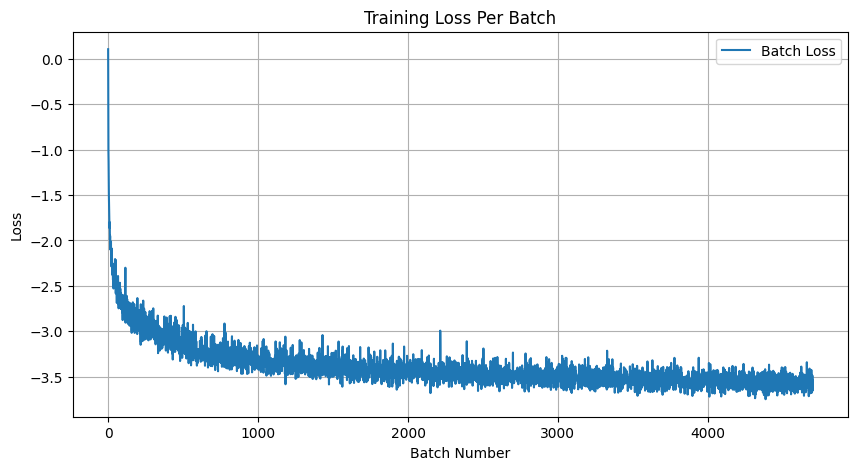

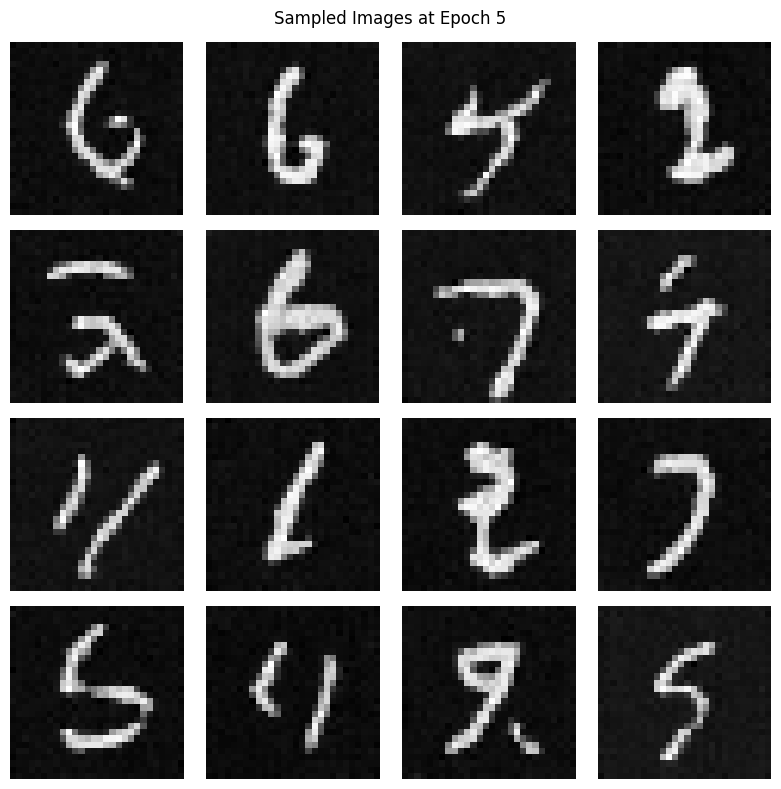

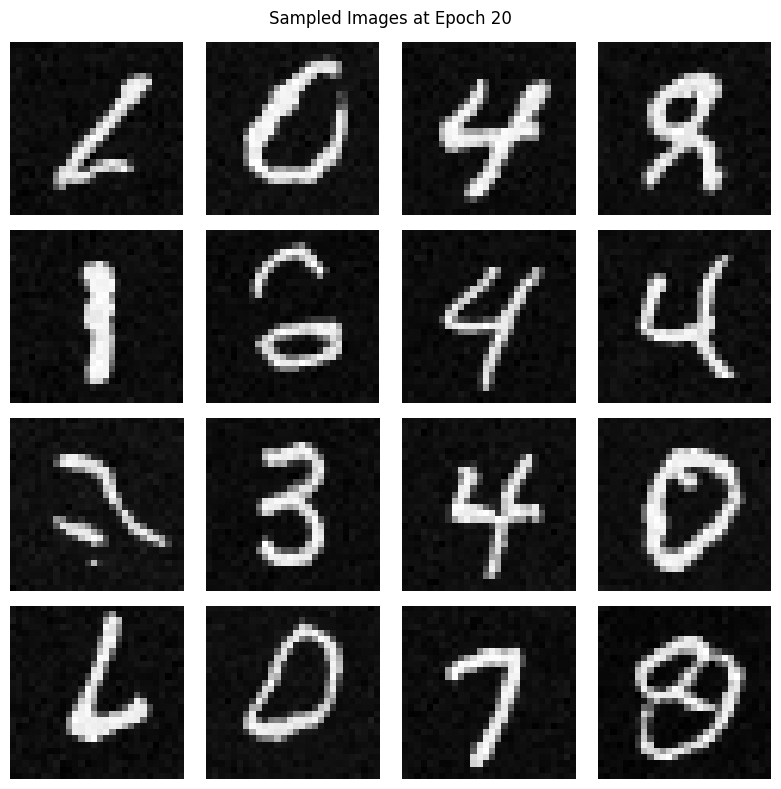

In [20]:
num_timesteps = 300
num_epochs = 20
learning_rate = 1e-3
gamma = 0.1 ** (1.0 / num_epochs)
losses = []

sample_epochs = {5, 20}  

sampled_images_dict = {}
unet = TimeConditionalUNet(        
        in_channels = 1,
        num_classes = num_timesteps,
        num_hiddens = 64,)
model = DDPM(unet).to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
for epoch in range(num_epochs):
    total_loss = 0
    for x, c in tqdm(train_loader):
        x, c = x.to(device), c.to(device)

        loss = model(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
        # print(loss.item())
        losses.append(torch.log(loss).item())
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

    if epoch + 1 in sample_epochs:
        model.eval()
        with torch.no_grad():
            num_samples = 16
            img_wh = (28, 28)
            sampled_images = []

            for _ in range(num_samples):
                sampled_image = model.sample(img_wh=img_wh, seed=epoch + 1)
                sampled_image = (
                    sampled_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
                )
                sampled_images.append(sampled_image)
            
            sampled_images_dict[epoch + 1] = sampled_images

        model.train()

plt.figure(figsize=(10, 5))
plt.plot(losses, label="Batch Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Training Loss Per Batch")
plt.legend()
plt.grid()
plt.show()

for epoch, sampled_images in sampled_images_dict.items():
    grid_size = (4, 4)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(8, 8))

    for i, image in enumerate(sampled_images):
        row = i // grid_size[1]
        col = i % grid_size[1]
        axes[row, col].imshow(image, cmap="gray")
        axes[row, col].axis("off")

    plt.suptitle(f"Sampled Images at Epoch {epoch}")
    plt.tight_layout()
    plt.show()


### Implementing class-conditioned UNet

In [21]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.enc1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        self.up2 = UpBlock(num_hiddens * 4, num_hiddens * 1)
        self.up1 = UpBlock(num_hiddens * 2, num_hiddens)

        self.dec1 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.final = nn.Conv2d(num_hiddens, in_channels, kernel_size=1)

        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)
        self.fc1_c = FCBlock(10, num_hiddens * 2)
        self.fc2_c = FCBlock(10, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # print(t)
        t = t.unsqueeze(1) / self.num_classes
        t1 = self.fc1_t(t).unsqueeze(2).unsqueeze(3)
        t2 = self.fc2_t(t).unsqueeze(2).unsqueeze(3)

        c1 = self.fc1_c(c).unsqueeze(2).unsqueeze(3)
        c2 = self.fc2_c(c).unsqueeze(2).unsqueeze(3)

        enc1 = self.enc1(x)
        enc2 = self.down1(enc1)
        enc3 = self.down2(enc2)

        # Bottleneck
        bottleneck = self.flatten(enc3)
        bottleneck = c1 * self.unflatten(bottleneck) + t1

        # Decoder
        dec2 = c2 * self.up2(torch.cat([bottleneck, enc3], dim=1)) + t2
        dec1 = self.up1(torch.cat([dec2, enc2], dim=1))
        out = self.dec1(torch.cat([dec1, enc1], dim=1))
        return self.final(out)



In [22]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    device = c.device
    N = x_0.size(0)
    num_classes = unet.num_classes
    one_hot_c = torch.nn.functional.one_hot(c, num_classes=num_classes).float()
    mask = torch.bernoulli(torch.full((N,), 1 - p_uncond)).to(x_0.device)
    one_hot_c = one_hot_c * mask.unsqueeze(1)

    t = torch.randint(0, num_ts, (N,), device=device)
    epsilon = torch.randn_like(x_0)

    x_t = add_noise(x_0, t, ddpm_schedule, epsilon)
    epsilon_pred = unet(x=x_t, t=t, c=one_hot_c)

    loss = torch.nn.functional.mse_loss(epsilon_pred, epsilon)

    return loss


In [23]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # YOUR CODE HERE.
    torch.manual_seed(seed)

    N = c.size(0)
    H, W = img_wh
    device = c.device

    x_t = torch.randn((N, 1, H, W), device=device)
    num_classes = unet.num_classes
    one_hot_c = torch.nn.functional.one_hot(c, num_classes=num_classes).float().to(device)
    zero_matrix = torch.zeros_like(one_hot_c)

    animation_cache = []

    betas = ddpm_schedule['betas']
    alphas = ddpm_schedule['alphas']
    alpha_bars = ddpm_schedule['alpha_bars']

    for t in range(num_ts, 0, -1): 
        t_tensor = torch.full((N,), t, device=device, dtype=torch.long)
        epsilon_pred_cond = unet(x_t, t=t_tensor, c=one_hot_c)
        epsilon_pred_uncond = unet(x_t, t=t_tensor, c=zero_matrix)

        epsilon_pred = (
            epsilon_pred_uncond + guidance_scale * (epsilon_pred_cond - epsilon_pred_uncond)
        )

        if t > 1:
            noise = torch.randn_like(x_t)
        else:
            noise = torch.zeros_like(x_t)

        beta_t = betas[t - 1]
        alpha_t = alphas[t - 1]
        alpha_bar_t = alpha_bars[t - 1]
        alpha_bar_prev_t = alpha_bars[t-2] if t > 1 else torch.tensor(1.0,device=device)


        x0 = (1 / torch.sqrt(alpha_bar_t)) * (x_t - torch.sqrt(1 - alpha_bar_t) * epsilon_pred)
        term1 = torch.sqrt(alpha_bar_prev_t) * beta_t / (1 - alpha_bar_t) * x0
        term2 = torch.sqrt(alpha_t) * (1 - alpha_bar_prev_t) / (1 - alpha_bar_t) * x_t
        term3 = torch.sqrt(beta_t) * noise
        x_t = term1 + term2 + term3
        animation_cache.append(x_t)


    return x_t, animation_cache

In [24]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

100%|██████████| 235/235 [00:20<00:00, 11.56it/s]


Epoch [1/20], Loss: 0.0884


100%|██████████| 235/235 [00:20<00:00, 11.62it/s]


Epoch [2/20], Loss: 0.0494


100%|██████████| 235/235 [00:20<00:00, 11.53it/s]


Epoch [3/20], Loss: 0.0421


100%|██████████| 235/235 [00:20<00:00, 11.64it/s]


Epoch [4/20], Loss: 0.0379


100%|██████████| 235/235 [00:20<00:00, 11.61it/s]


Epoch [5/20], Loss: 0.0360


100%|██████████| 235/235 [00:20<00:00, 11.60it/s]


Epoch [6/20], Loss: 0.0349


100%|██████████| 235/235 [00:20<00:00, 11.66it/s]


Epoch [7/20], Loss: 0.0333


100%|██████████| 235/235 [00:20<00:00, 11.56it/s]


Epoch [8/20], Loss: 0.0327


100%|██████████| 235/235 [00:20<00:00, 11.59it/s]


Epoch [9/20], Loss: 0.0313


100%|██████████| 235/235 [00:20<00:00, 11.59it/s]


Epoch [10/20], Loss: 0.0311


100%|██████████| 235/235 [00:20<00:00, 11.61it/s]


Epoch [11/20], Loss: 0.0307


100%|██████████| 235/235 [00:20<00:00, 11.62it/s]


Epoch [12/20], Loss: 0.0302


100%|██████████| 235/235 [00:20<00:00, 11.66it/s]


Epoch [13/20], Loss: 0.0297


100%|██████████| 235/235 [00:20<00:00, 11.24it/s]


Epoch [14/20], Loss: 0.0293


100%|██████████| 235/235 [00:20<00:00, 11.29it/s]


Epoch [15/20], Loss: 0.0295


100%|██████████| 235/235 [00:21<00:00, 10.97it/s]


Epoch [16/20], Loss: 0.0288


100%|██████████| 235/235 [00:20<00:00, 11.20it/s]


Epoch [17/20], Loss: 0.0286


100%|██████████| 235/235 [00:25<00:00,  9.08it/s]


Epoch [18/20], Loss: 0.0286


100%|██████████| 235/235 [00:20<00:00, 11.49it/s]


Epoch [19/20], Loss: 0.0285


100%|██████████| 235/235 [00:20<00:00, 11.42it/s]


Epoch [20/20], Loss: 0.0281


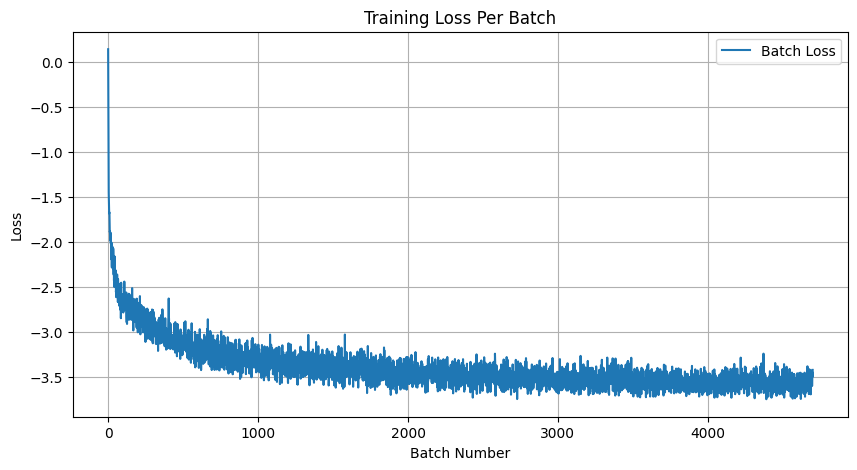

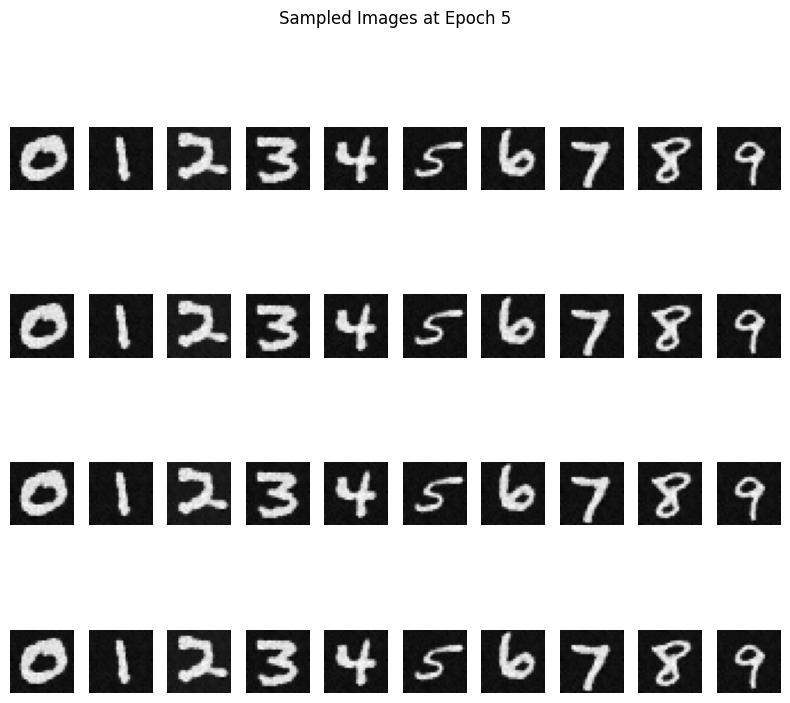

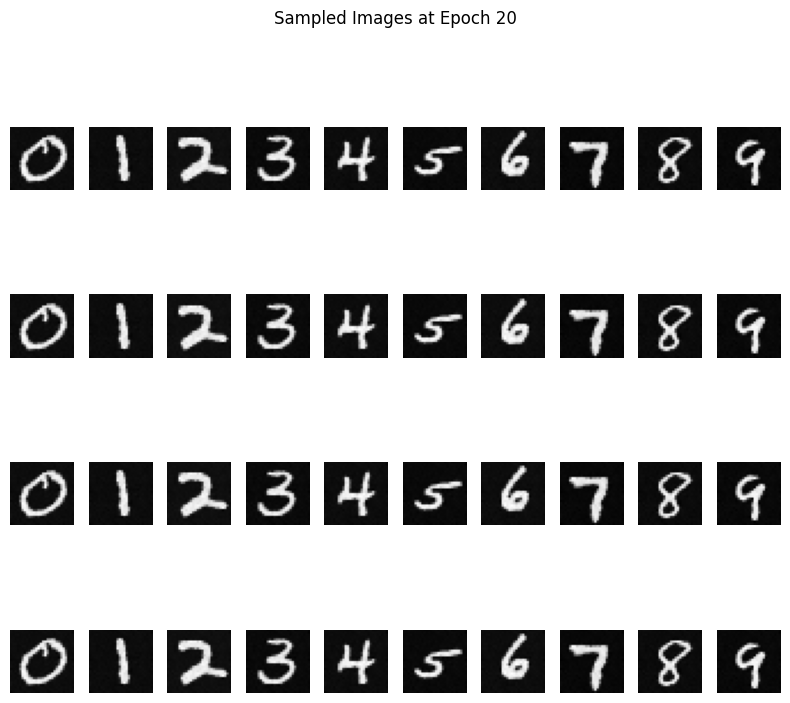

In [45]:
num_epochs = 20
losses = []

sample_epochs = {5, 20}  

sampled_images_dict = {}
unet = ClassConditionalUNet(        
        in_channels = 1,
        num_classes = 10,
        num_hiddens = 64,)
model = DDPM(unet).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for x, c in tqdm(train_loader):
        x, c = x.to(device), c.to(device)

        loss = model(x, c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(torch.log(loss).item())
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

    if epoch + 1 in sample_epochs:
        model.eval()
        samples = []
        with torch.no_grad():
            for label in range(10):
                for _ in range(4):
                    class_label = torch.tensor([label], device=device)
                    sample, animation = model.sample(img_wh=img_wh, c=class_label)
                    sample = sample.squeeze(0).cpu().numpy().transpose(1, 2, 0)
                    samples.append((label, sample))

            sampled_images_dict[epoch + 1] = samples

        model.train()

plt.figure(figsize=(10, 5))
plt.plot(losses, label="Batch Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Training Loss Per Batch")
plt.legend()
plt.grid()
plt.show()

for epoch, sampled_images in sampled_images_dict.items():
    grid_size = (4, 10)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(8, 8))

    for i, (c, image) in enumerate(sampled_images):
        row = i % grid_size[0]
        col = c 

        axes[row, col].imshow(image, cmap="gray")
        axes[row, col].axis("off")

    plt.suptitle(f"Sampled Images at Epoch {epoch}")
    plt.tight_layout()
    plt.show()



100%|██████████| 235/235 [00:20<00:00, 11.69it/s]


Epoch [1/3], Loss: 0.0884


100%|██████████| 235/235 [00:20<00:00, 11.62it/s]


Epoch [2/3], Loss: 0.0497


100%|██████████| 235/235 [00:20<00:00, 11.36it/s]


Epoch [3/3], Loss: 0.0422


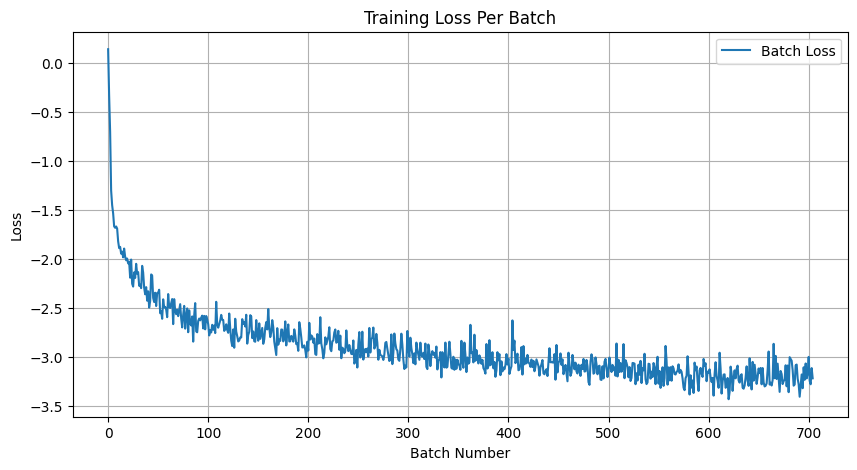

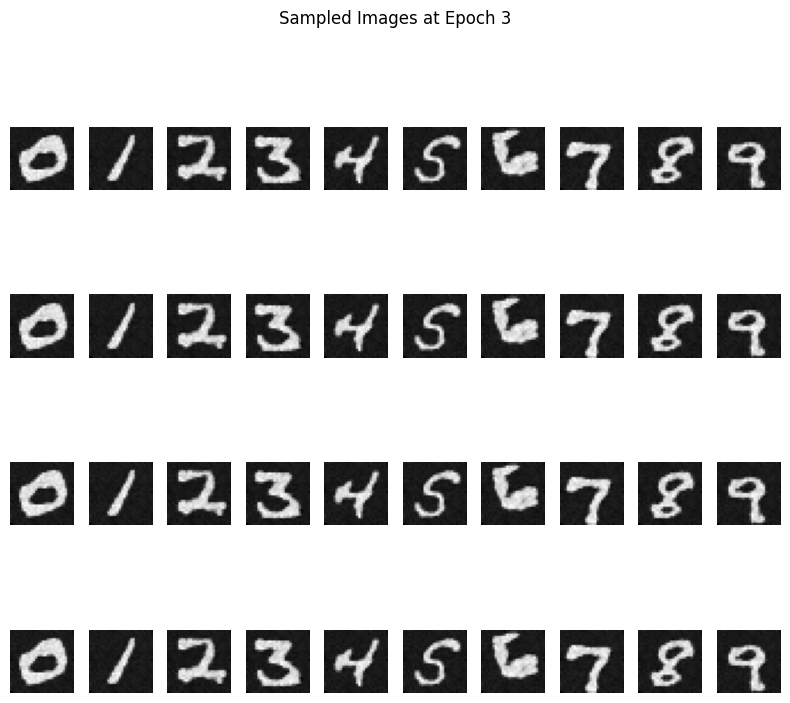

In [47]:
num_epochs = 3
losses = []

sample_epochs = {3}  

sampled_images_dict = {}
unet = ClassConditionalUNet(        
        in_channels = 1,
        num_classes = 10,
        num_hiddens = 64,)
model = DDPM(unet).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for x, c in tqdm(train_loader):
        x, c = x.to(device), c.to(device)

        loss = model(x, c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(torch.log(loss).item())
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

    if epoch + 1 in sample_epochs:
        model.eval()
        samples = []
        with torch.no_grad():
            for label in range(10):
                for _ in range(4):
                    class_label = torch.tensor([label], device=device)
                    sample, animation = model.sample(img_wh=img_wh, c=class_label)
                    sample = sample.squeeze(0).cpu().numpy().transpose(1, 2, 0)
                    samples.append((label, sample))

            sampled_images_dict[epoch + 1] = samples

        model.train()

plt.figure(figsize=(10, 5))
plt.plot(losses, label="Batch Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Training Loss Per Batch")
plt.legend()
plt.grid()
plt.show()

for epoch, sampled_images in sampled_images_dict.items():
    grid_size = (4, 10)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(8, 8))

    for i, (c, image) in enumerate(sampled_images):
        row = i % grid_size[0]
        col = c 

        axes[row, col].imshow(image, cmap="gray")
        axes[row, col].axis("off")

    plt.suptitle(f"Sampled Images at Epoch {epoch}")
    plt.tight_layout()
    plt.show()

